In [4]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [5]:
from sklearn.cluster import KMeans

In [6]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,0,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5


In [7]:
df_clean = df.drop_duplicates(subset=["Date", "id"], keep="last").copy()

# Song Popularity Over time

In [8]:
# all time hit, 6RUKPb4LETWmmr3iAEQktW, 5uCax9HTNlzGybIStD3vDh
# old release, but popular in 2022, 4xkOaSrkexMciUUogZKVTS, 4UKCKdYiLN6IMA5ZESUTL7, 1kKYjjfNYxE0YYgLa7vgVY
# popu. on and off, 2jyjhRf6DVbMPU5zxagN2h, 60a0Rd6pjrkxjPbaKzXjfq
# popu. on festival, 2TE4xW3ImvpltVU0cPcKUn, 15coTBAzEN1bOeipoNDZAR

id: 6kls8cSlUyHW2BUOkDJIZE | Total count: 251
Song: Hate Me (with Juice WRLD) | Artists: Ellie Goulding | Continent: Europe


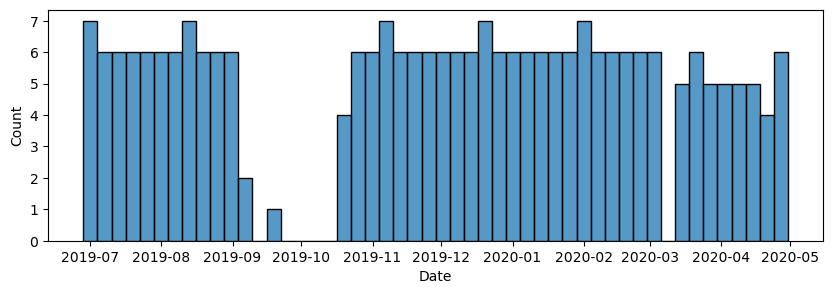

<Axes: xlabel='Date', ylabel='Points (Total)'>

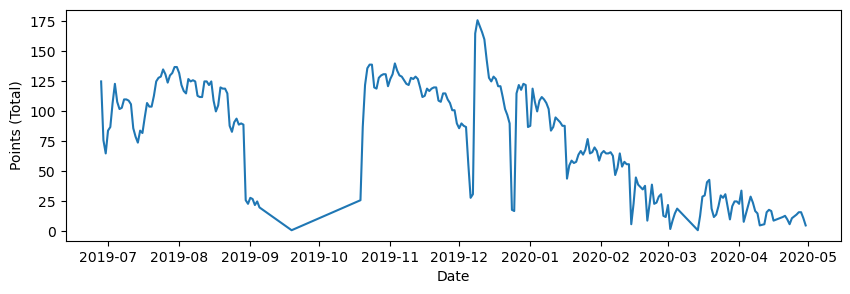

In [133]:
sample = df_clean.sample(n=1).iloc[0]
# sample = df_clean[df_clean["id"] == "6RUKPb4LETWmmr3iAEQktW"].iloc[0]
df_focus = df_clean[df_clean["id"] == sample["id"]]

print(f'id: {sample["id"]} | Total count: {df_focus.shape[0]}')
print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

# Artist Popularity Over time

Artists: Yng Lvcas, Peso Pluma | Populary day count: 73 | Total song: 1


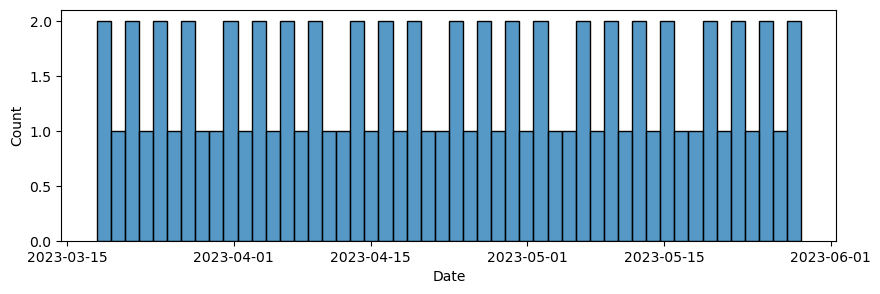

<Axes: xlabel='Date', ylabel='Points (Total)'>

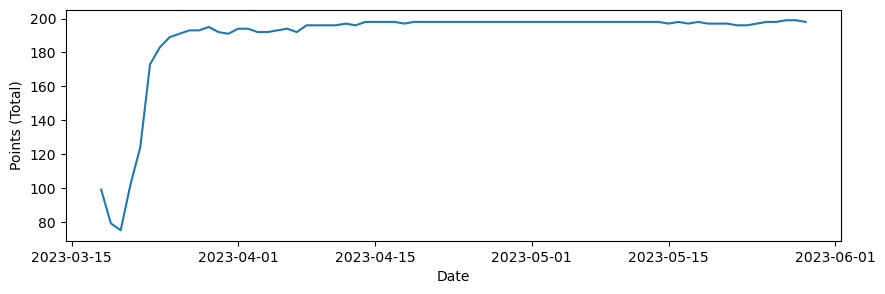

In [135]:
Artists = "Yng Lvcas, Peso Pluma"

df_focus = df_clean[df_clean["Artists"] == Artists]
print(f'Artists: {Artists} | Populary day count: {df_focus.shape[0]} | Total song: {len(df_focus["Title"].unique())}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

# Name-included Popularity Over time

Word: summer | Populary day count: 1125 | Total song: 25


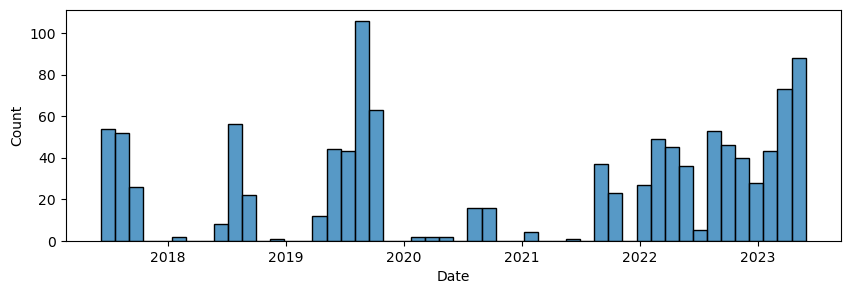

<Axes: xlabel='Date', ylabel='Points (Total)'>

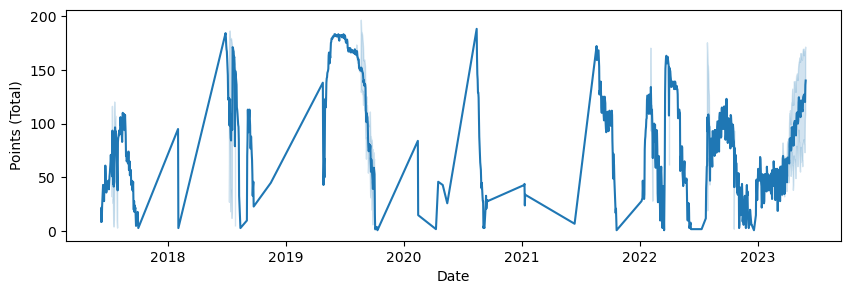

In [166]:
WordIncluded = "summer"

df_focus = df_clean[df_clean['Title'].str.contains("(?i)" + WordIncluded)]
print(f'Word: {WordIncluded} | Populary day count: {df_focus.shape[0]} | Total song: {len(df_focus["Title"].unique())}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

## Clustering (Draft)

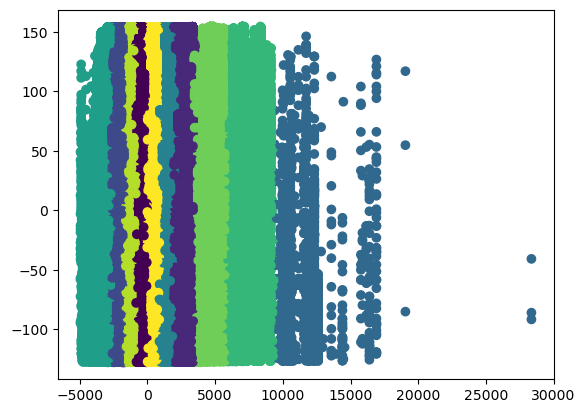

In [59]:
df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = df_main_features.copy()

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
kmeans.fit(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
labels = kmeans.labels_

pca = PCA(n_components=4)  # Reduce to 2 dimensions
X_2d = pca.fit_transform(df_cluster_original)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

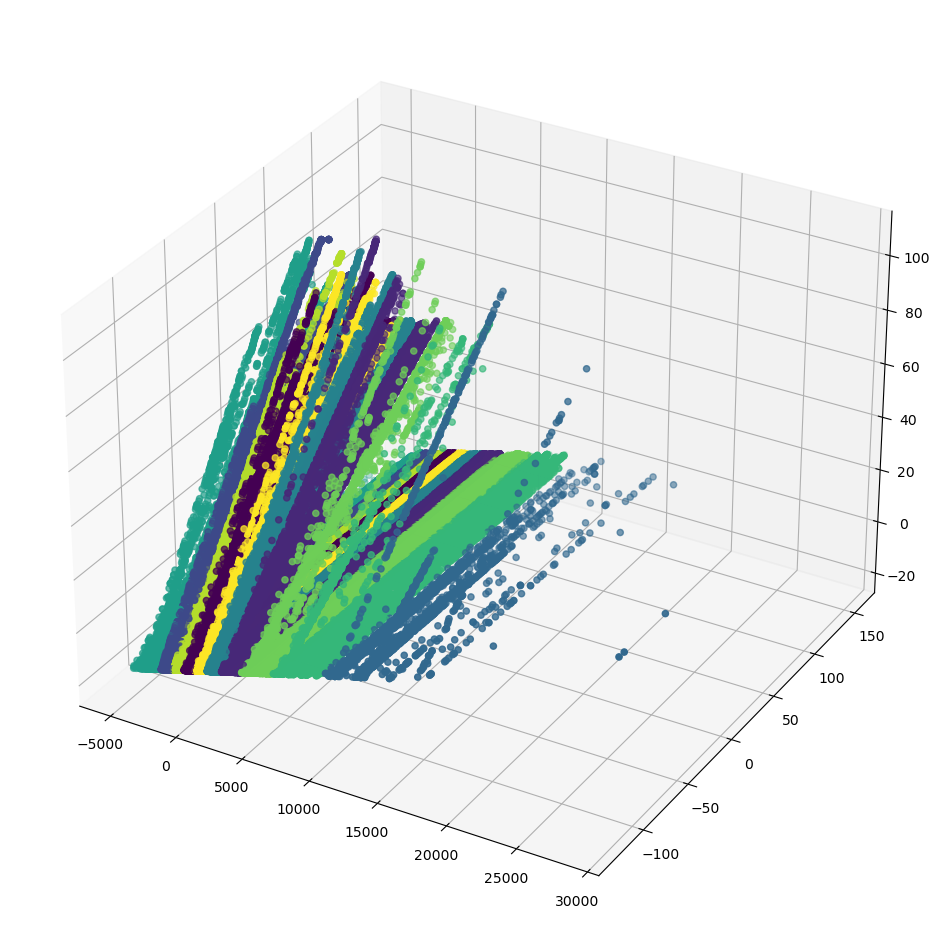

In [60]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_2d[:, 0], X_2d[:, 1], X_2d[:, 2], c=labels)
plt.show()

## Explore data for each cluster

In [254]:
# Filter songs based on a specific cluster
pd.options.display.max_colwidth = 100
df.filter(items=df_cluster[df_cluster["cluster"] == 3].index, axis=0)

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
274,186,I AM,IVE,2023-05-29,0.683,0.875,-4866.0,0.055,0.012,0.0,...,IVE,Nationality 1,South Korea,Asia,15,15.0,70t7Q6AYG6ZgTYmJWcnkUM,https://open.spotify.com/track/70t7Q6AYG6ZgTYmJWcnkUM,Monday,5
277,189,Shut up My Moms Calling,Hotel Ugly,2023-05-29,0.485,0.409,-10711.0,0.101,0.325,0.0,...,Hotel Ugly,Nationality 1,United States,Anglo-America,12,12.0,3hxIUxnT27p5WcmjGUXNwx,https://open.spotify.com/track/3hxIUxnT27p5WcmjGUXNwx,Monday,5
278,190,Lover,Taylor Swift,2023-05-29,0.359,0.543,-7582.0,0.092,0.492,0.0,...,Taylor Swift,Nationality 1,United States,Anglo-America,11,11.0,1dGr1c8CrMLDpV6mPbImSI,https://open.spotify.com/track/1dGr1c8CrMLDpV6mPbImSI,Monday,5
279,191,Demons,Imagine Dragons,2023-05-29,0.505,0.710,-3015.0,0.032,0.190,0.0,...,Imagine Dragons,Nationality 1,United States,Anglo-America,10,10.0,5qaEfEh1AtSdrdrByCP7qR,https://open.spotify.com/track/5qaEfEh1AtSdrdrByCP7qR,Monday,5
280,192,Shivers,Ed Sheeran,2023-05-29,0.788,0.859,-2724.0,0.086,0.281,0.0,...,Ed Sheeran,Nationality 1,United Kingdom,Europe,9,9.0,3xWGA8pa0IKFI7IMPri4P0,https://open.spotify.com/track/3xWGA8pa0IKFI7IMPri4P0,Monday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651929,195,Taped up Heart (feat. Clara Mae),KREAM,2017-01-01,0.675,0.937,-3525.0,0.051,0.152,0.0,...,KREAM,Nationality 1,Norway,Europe,6,6.0,26hcyzSE154xMZCbFdtInA,https://open.spotify.com/track/26hcyzSE154xMZCbFdtInA,Sunday,1
651930,196,White Iverson,Post Malone,2017-01-01,0.675,0.562,-7678.0,0.035,0.233,0.0,...,Post Malone,Nationality 1,United States,Anglo-America,5,5.0,6eT7xZZlB2mwyzJ2sUKG6w,https://open.spotify.com/track/6eT7xZZlB2mwyzJ2sUKG6w,Sunday,1
651933,199,Secrets,The Weeknd,2017-01-01,0.665,0.771,-5779.0,0.053,0.016,0.0,...,The Weeknd,Nationality 1,Canada,Anglo-America,2,2.0,3DX4Y0egvc0slLcLl31h2p,https://open.spotify.com/track/3DX4Y0egvc0slLcLl31h2p,Sunday,1
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,-6125.0,0.248,0.076,0.0,...,JAY-Z,Nationality 1,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O,https://open.spotify.com/track/2KpCpk6HjXXLb7nnXoXA5O,Sunday,1


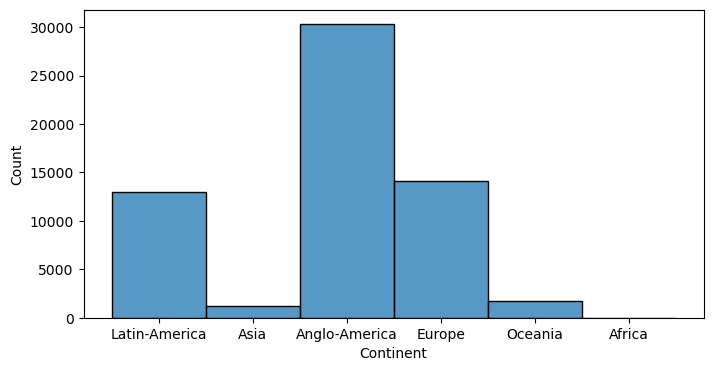

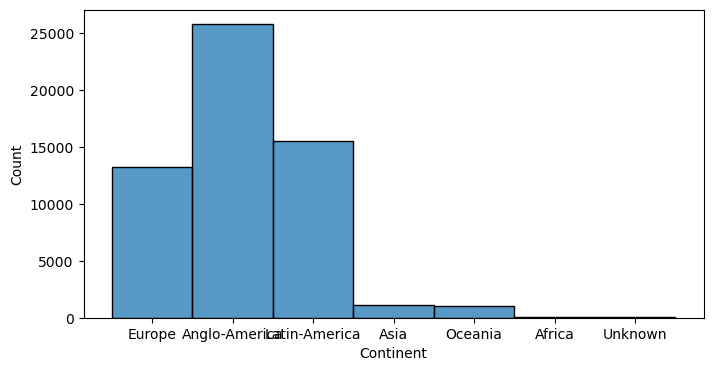

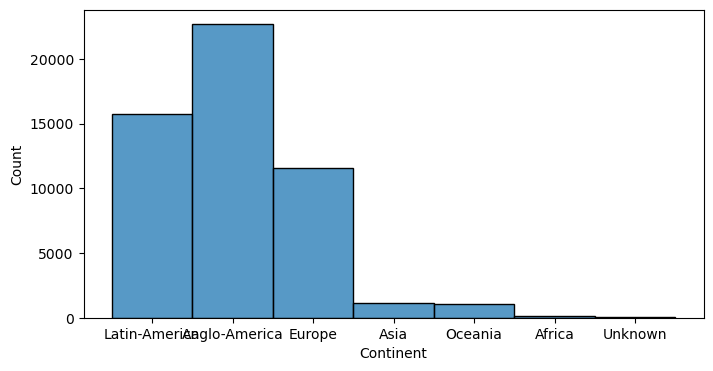

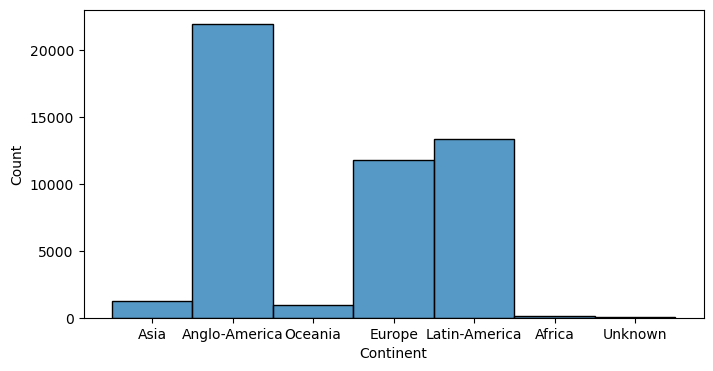

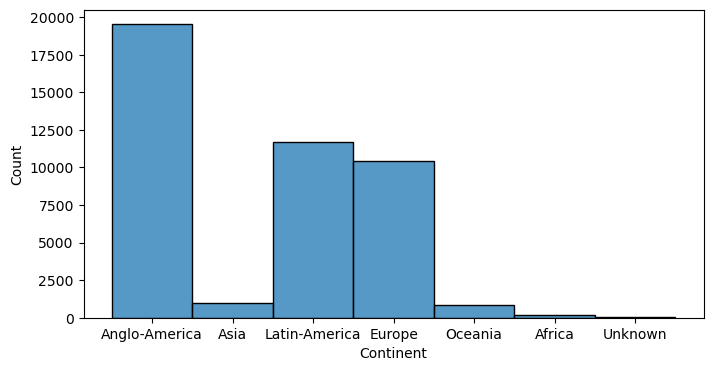

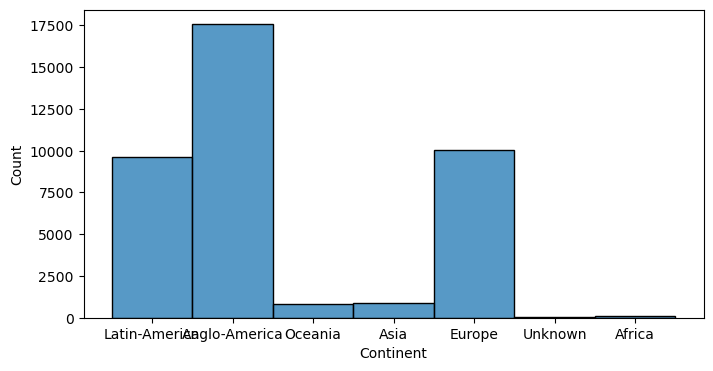

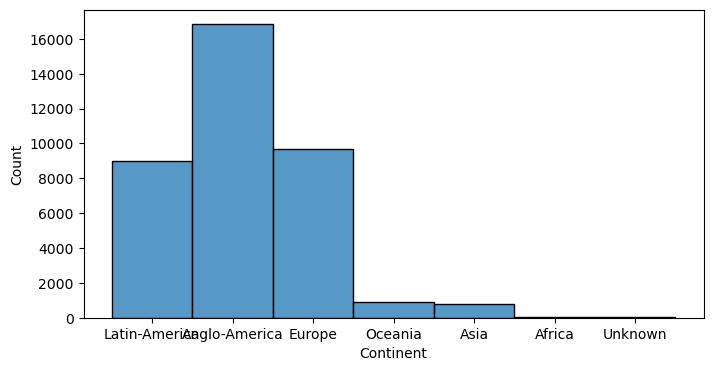

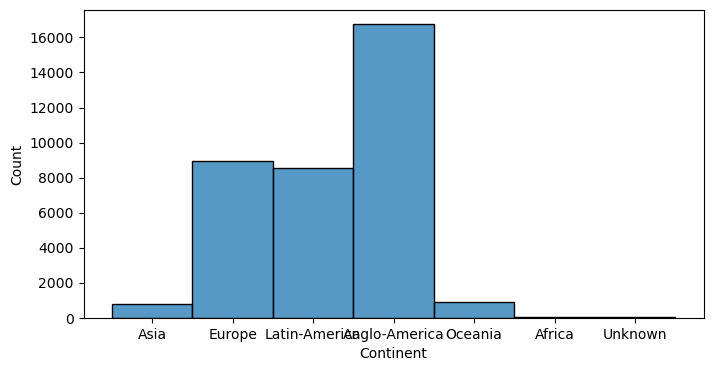

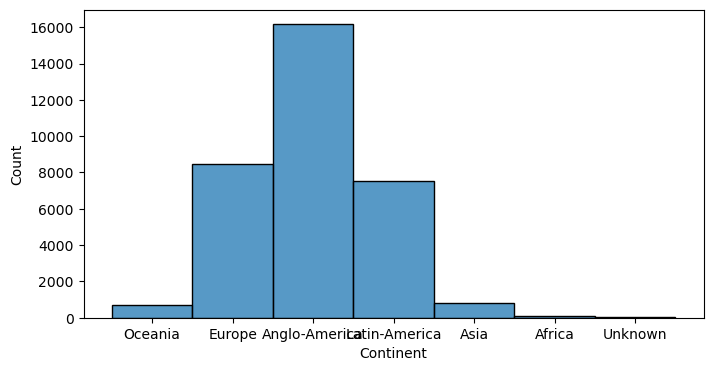

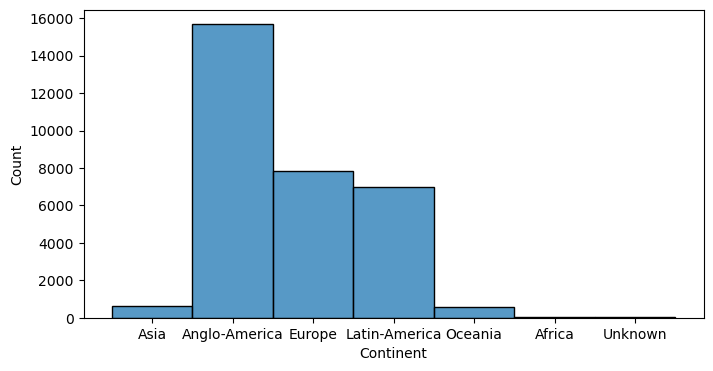

In [196]:
for cluster in df_cluster["cluster"].unique():
    plt.figure(figsize=(8,4))
    sns.histplot(df.filter(items=df_cluster[df_cluster["cluster"] == cluster].index, axis=0)["Continent"])
    plt.show()